In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from segmentation_models import Unet
from segmentation_models.utils import set_trainable

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50
from keras.models import Model, load_model
from keras.layers import Input , Concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.initializers import he_normal
from keras.regularizers import l2
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
im_width = 256
im_height = 256
border = 5
im_chan = 3
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

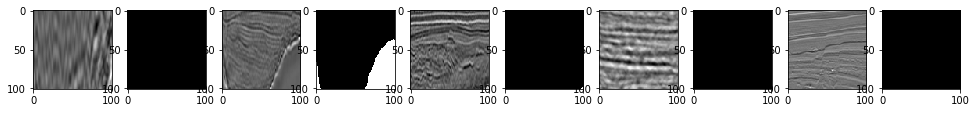

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('data/train/images/' + img_name + '.png')
    img_mask = load_img('data/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), 256, 256 , 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
sum_whites = 0
for n, id_ in enumerate(train_ids):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (256, 256 , 3), preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (256, 256, 1), preserve_range=True)
    sum_whites += np.sum(Y_train[n])

print('Done!')

print("Salt in the dataset is {}".format(sum_whites*1.0 / (X_train.shape[0] * 256*256)))

Getting and resizing train images and masks ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Done!
Salt in the dataset is 0.24794946670532225


In [6]:
Y_train[0].shape

(256, 256, 1)

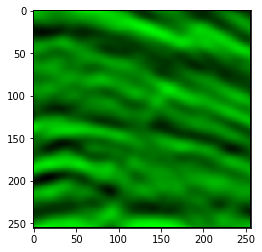

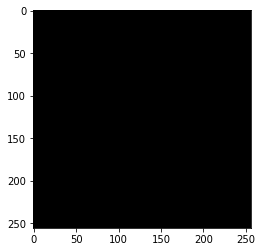

In [7]:
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [8]:
X_train , X_val , Y_train , Y_val = train_test_split(X_train , Y_train , train_size = 0.9 , random_state = 1801)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
image_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

mask_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 1801 , batch_size = 16)
train_mask_gen = mask_generator.flow(Y_train , seed = 1801 , batch_size = 16)

val_img_gen = val_image_generator.flow(X_val , seed = 1801 , batch_size = 16)
val_mask_gen = val_mask_generator.flow(Y_val , seed = 1801 , batch_size = 16)

In [10]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [11]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [13]:
model = Unet(backbone_name='inceptionresnetv2', input_shape = (256,256,3))

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'binary_crossentropy' , metrics = [mean_iou , 'acc'])

In [16]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_mean_iou' , factor = 0.5 , 
                               mode = 'max' , patience = 5 , verbose = 2 , min_delta = 0.01)
checkpointer = ModelCheckpoint('inceptionresnetv2_unet_1801.h5', monitor='val_mean_iou', 
                               verbose=2, save_best_only=True , save_weights_only = False , mode = 'max')
early_stopper = EarlyStopping(monitor = 'val_mean_iou' , mode = 'max' , patience = 10)

In [ ]:
results = model.fit_generator(train_gen , steps_per_epoch = 1125 , epochs = 100 ,
                              validation_data = val_gen , validation_steps = 25 ,
                              callbacks=[checkpointer , lr_reducer, early_stopper] , verbose = 1)

In [17]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (256, 256, 3) , preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Done!


In [18]:
model = load_model("inceptionresnetv2_unet_1801.h5" , custom_objects = {'mean_iou' : mean_iou})

In [19]:
def predict_result(model, x_test, img_size_target):
    
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    
    preds_test += np.array([ np.fliplr(a) for a in 
                            model.predict(np.array([np.fliplr(x) 
                            for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    
    preds_test += np.array([ np.flipud(a) for a in 
                            model.predict(np.array([np.flipud(x) 
                            for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    
    preds_test += np.array([ np.fliplr(np.flipud(a)) for a in 
                            model.predict(np.array([np.fliplr(np.flipud(x)) 
                            for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    
    return preds_test/4.0

In [20]:
preds_val = predict_result(model, X_val, 256)
preds_test = predict_result(model, X_test, 256)

preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [21]:
model.evaluate(X_val , Y_val , verbose = 1)

400/400 [==============================] - 84s 211ms/step


[0.35155375212430956, 0.8298799228668213, 0.9510441970825195]

In [22]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (101, 101), 
                                       mode='constant', preserve_range=True))

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(Y_val, np.int32(preds_val > t)) for t in thres]

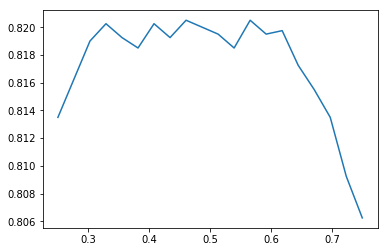

In [25]:
plt.plot(thres, thres_ioc)

In [26]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.4605263157894737, 0.8205000000000001)

In [27]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,fn in enumerate(test_ids)}

In [28]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')